# Tools

In [1]:
import os, sys

import numpy as np, tqdm
from matplotlib import pyplot as plt

import waveprop, ngi, imp
imp.reload(waveprop)

<module 'waveprop' from '/Users/y9z/Documents/GitHub/cupi2d-master/nGI/waveprop.py'>

In [2]:
%matplotlib inline

In [3]:
ngi.nSLD_Si*70e-6*6.7e-10/np.pi

3.091628213579433

# One wavelength

In [4]:
wavelength = 3.35e-10
g0_slit_width=400e-6
g0_period=1075e-6
g1_thickness = 45e-6
g1_period = 7.97e-6
np_g1 = 64 # number of points for the grating 1 period
npoints = 2**12 # total number of points to simulate transversally

In [5]:
b4_gr1, gr1_binary, gr1, after_gr1, b4_gr2 = ngi.nGI_spherical(wavelength = wavelength, npoints=npoints, np_g1=np_g1)

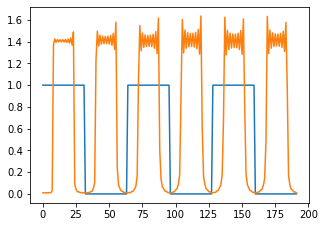

In [6]:
plt.figure(figsize=(5,3.6))
sl = slice(npoints//2, npoints//2+np_g1*3)
plt.plot(gr1_binary[sl])
plt.plot(np.abs(b4_gr2)[sl])

In [7]:
x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V = ngi.calc_visibitilty(
    wavelength, g0_slit_width=g0_slit_width, g0_period=g0_period, npoints=npoints, np_g1=np_g1)
print(V)

0.29455546684224904


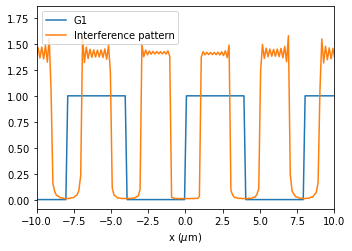

In [8]:
plt.figure(figsize=(5,3.6))
xp = x*1e6
plt.plot(xp, gr1_binary, label='G1')
plt.plot(xp, np.abs(b4_gr2), label='Interference pattern')
plt.legend(loc='upper left')
plt.xlim(-10, 10)
plt.xlabel('x ($\mu$m)')
plt.tight_layout()

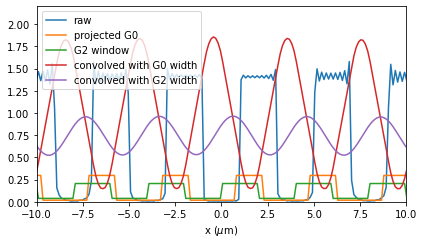

In [9]:
plt.figure(figsize=(6,3.5))
xp = x*1e6
plt.plot(xp, np.abs(y0), label='raw')
plt.plot(xp, y_projected_G0*500, label='projected G0')
# plt.plot(xp, gr0[sl], label='G1')
plt.plot(xp, y_G2*500, label='G2 window')
plt.plot(xp, y0_X_G0, label='convolved with G0 width')
plt.plot(xp, y0_X_G0_X_G2, label='convolved with G2 width')
plt.xlim(-10, 10)
plt.ylim(0, 2.2)
plt.xlabel('x ($\mu$m)')
plt.legend(loc='upper left')
plt.tight_layout()

In [10]:
V

0.29455546684224904

## Talbot Carpet

In [11]:
zt = (g1_period/2)**2/wavelength/2

Lx = npoints*g1_period/np_g1
X = np.linspace(-Lx/2, Lx/2, npoints)
N = 2000
field = np.zeros((N, npoints), dtype='complex')
zs = np.linspace(0, 8*zt, N)
for iz, z in enumerate(zs):
    field[iz] = waveprop.propTF_RayleighSommerfeld_1D(after_gr1,Lx,wavelength,z)

In [12]:
zg, xg = np.meshgrid(zs/zt, X)

/tmp/ipykernel_2703918/590329064.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(zg[sl], xg[sl]*1e6, np.abs(field).T[sl]) #, cmap='jet')


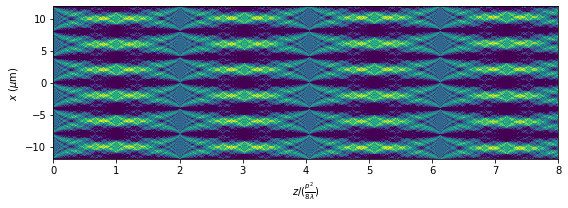

In [13]:
plt.figure(figsize=(8,3))
sl = slice(int(npoints//2-np_g1*1.5),int(npoints//2+np_g1*1.5)), slice(None, None)
plt.pcolormesh(zg[sl], xg[sl]*1e6, np.abs(field).T[sl]) #, cmap='jet')
# plt.colorbar()
plt.clim(.5, 2)
plt.xlabel(r'$z$/($\frac{p^2}{8\lambda}$)')
plt.ylabel('$x$ ($\mu$m)')
plt.tight_layout()

# Scan wavelength for Visibility

In [14]:
%%time
Vs = []
wls = np.arange(.5, 12, .1)
for wl in wls:
    x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V = ngi.calc_visibitilty(
        wl*1e-10, g0_slit_width=g0_slit_width, g0_period=g0_period, npoints=npoints, np_g1=np_g1)
    Vs.append(V)

CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.13 s


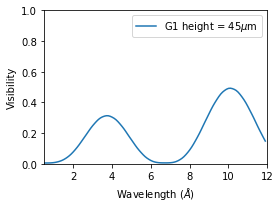

In [15]:
plt.figure(figsize=(4,3))
plt.plot(wls, Vs, label = 'G1 height = 45$\mu$m')
plt.ylim(0,1)
plt.xlim(0.5, 12)
plt.ylabel('Visibility')
plt.xlabel(r'Wavelength ($\AA$)')
plt.legend()
plt.tight_layout()

# Simplified Talbot Length Visibility
* assume it is pi grating
* if n is even visibility is zero
* if n is odd visibility is one

In [24]:
d12 =  2.379e-2

In [48]:
vis_tl = np.sin( (d12/(g1_period**2/8/(wls*1e-10)))%2 /2.0 *np.pi )**2

<IPython.core.display.Javascript object>


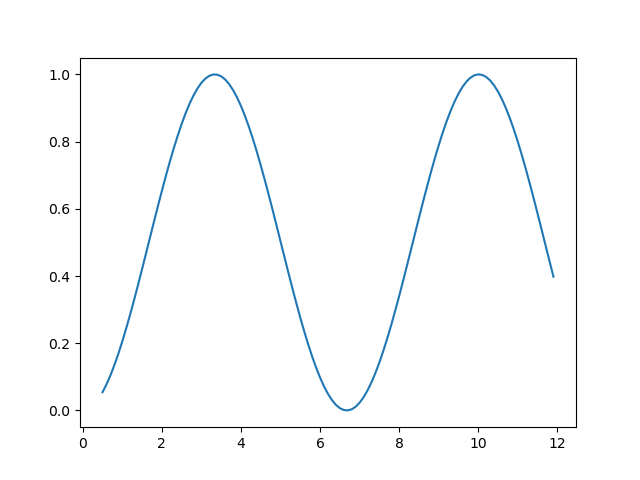

In [49]:
plt.figure()
plt.plot(wls, vis_tl)

# Scan wavelength and G1 thickness

In [13]:
import tqdm

In [14]:
%%time
Vmat = []
wls = np.arange(.5, 12, .1)
g1ts = np.arange(5, 150, 2.)
for wl in tqdm.tqdm(wls):
    _vs = []
    for g1t in g1ts:
        x, y0, y_projected_G0, y_G2, y0_X_G0, y0_X_G0_X_G2, V  = ngi.calc_visibitilty(
            wl*1e-10, g0_slit_width=g0_slit_width, g0_period=g0_period, 
            g1_thickness=g1t*1e-6, npoints=npoints, np_g1=np_g1)
        _vs.append(V)
    Vmat.append(_vs)

100%|██████████| 115/115 [00:40<00:00,  2.81it/s]

CPU times: user 40.9 s, sys: 30.5 ms, total: 41 s
Wall time: 41 s


<IPython.core.display.Javascript object>


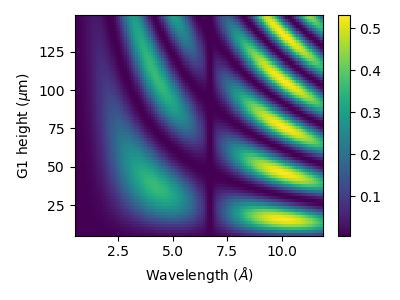

<ipython-input-15-a31a8439856c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(wlg, g1tg, Vmat.T)


In [15]:
Vmat = np.array(Vmat)
plt.figure(figsize=(4,3))
wlg, g1tg = np.meshgrid(wls, g1ts)
plt.pcolormesh(wlg, g1tg, Vmat.T)
plt.colorbar()
plt.ylabel('G1 height ($\mu$m)')
plt.xlabel('Wavelength ($\AA$)')
plt.tight_layout()